In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler,normalize,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case.

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns.

The target field, called **custcat**, has four possible service categories that correspond to the four customer groups, as follows:

1. Basic Service
2. E-Service
3. Plus Service
4. Total Service

Our objective is to build a classifier to predict the service category for unknown cases. We will use a specific type of classification called K-nearest neighbors.


## laod Data

In [2]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/teleCust1000t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


## Data Visualization and Analysis

In [4]:
df.custcat.unique()

array([1, 4, 3, 2])

In [16]:
customer_category_value_counts = df['custcat'].value_counts().sort_values()
customer_category_value_counts

custcat
2    217
4    236
1    266
3    281
Name: count, dtype: int64

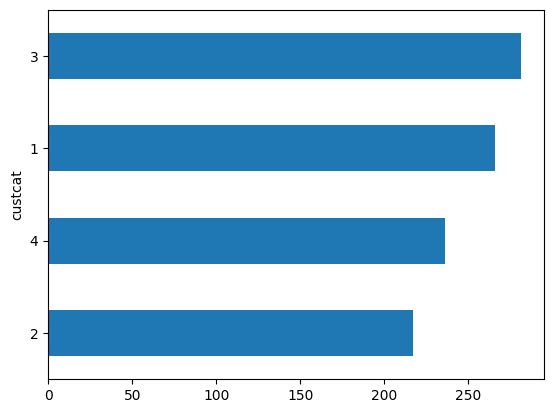

In [17]:
customer_category_value_counts.plot(kind = 'barh')
plt.show()

Most of the people receieved plus service, while least of them get the scope of getting E-Service

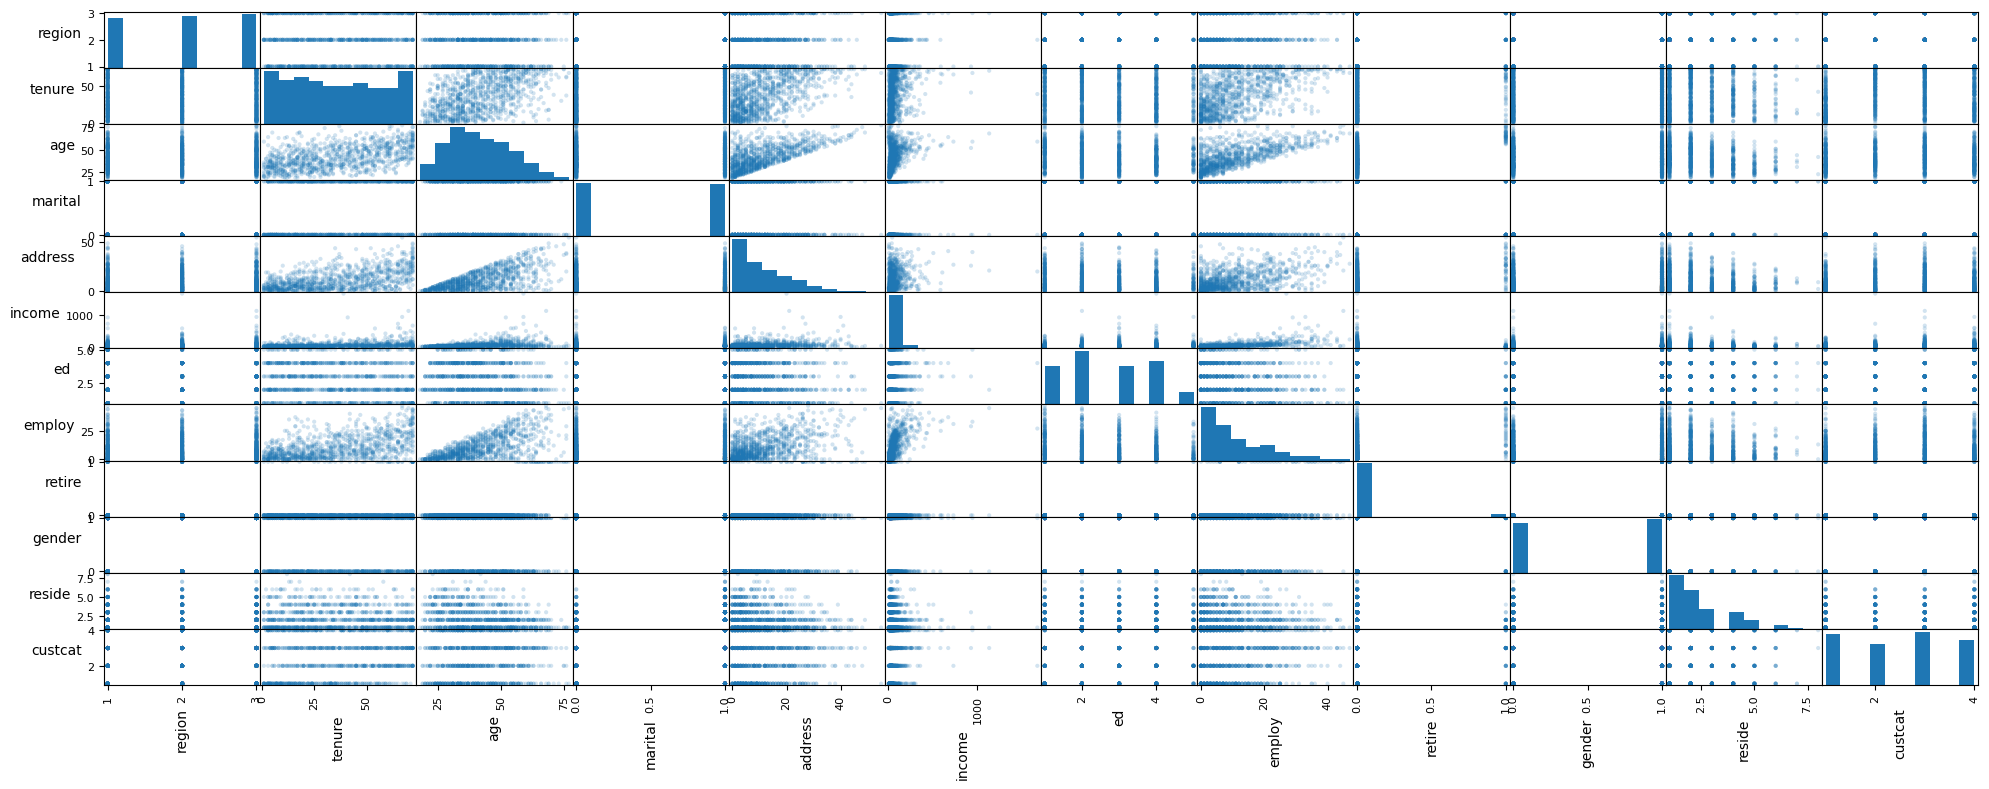

In [22]:
axes = pd.plotting.scatter_matrix(df,alpha = 0.2, figsize = (20,8))

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace = 0,hspace = 0)
plt.show()

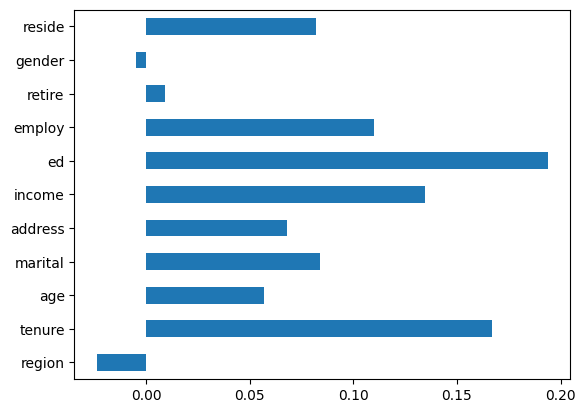

In [23]:
# Find the correlation between the target value with other features
correlation = df.corr()['custcat'].drop('custcat')
correlation.plot(kind = 'barh')
plt.show()

as we can see, no features are closely correlated with the output custcat. Among all the features ed has the highest correlation, whereas genger has the lowest correlation

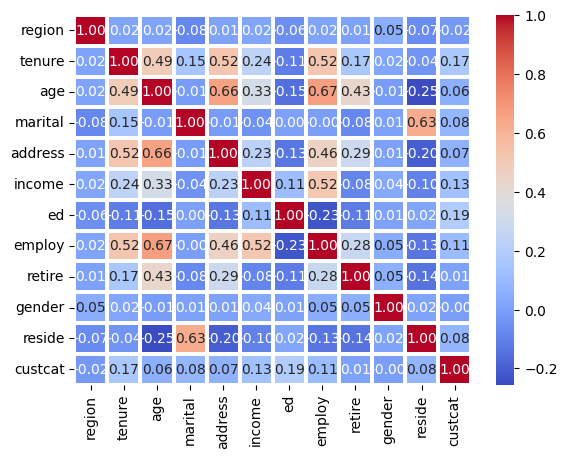

In [32]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1.5)
plt.show()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


All of them are numerical values. So we don't have to transform the categories

## Separate the input and the target features

In [34]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [35]:
X.shape

(1000, 11)

In [36]:
y.shape

(1000,)

In [37]:
def preprocessing(data,test_size):
    X = data.iloc[:,:-1].values
    y = data.iloc[:,-1].values

    # normalize the data
    X = StandardScaler().fit_transform(X)
    X = normalize(X,norm = 'l1',axis = 1, copy = False)

    # split the data
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size,random_state= 42)

    return X_train,X_test,y_train,y_test
    

In [38]:
X_train,X_test,y_train,y_test = preprocessing(df,test_size=0.2)

In [40]:
X_train.shape, X_test.shape

((800, 11), (200, 11))

In [42]:
X_train[:5]

array([[-0.00375519, -0.14692405, -0.0963335 ,  0.14064751, -0.03523452,
        -0.07618314,  0.15146738, -0.15182207, -0.0309237 ,  0.13459139,
        -0.03211756],
       [ 0.16293361, -0.0288128 , -0.08319687, -0.13455753, -0.03438987,
         0.03488871,  0.14783634, -0.05377298, -0.03018239,  0.13136491,
         0.15806399],
       [-0.06085351,  0.08298837,  0.12892449, -0.04809179,  0.12261785,
        -0.02021947, -0.0664348 ,  0.15913504,  0.2187316 ,  0.04695073,
        -0.04505237],
       [-0.13431312, -0.1281886 , -0.15958248, -0.10614602, -0.08030087,
        -0.04162127, -0.05888091, -0.10625483, -0.02380945, -0.11092221,
         0.04998025],
       [-0.11907706,  0.16239016,  0.1311211 ,  0.09600626,  0.00423323,
        -0.01113615,  0.02559514,  0.09444686, -0.02110858,  0.09187234,
         0.24301312]])

## KNN Classification

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_model = knn_classifier.fit(X_train,y_train)

In [59]:
yhat = knn_model.predict(X_test)

In [60]:
print("Test set Accuracy: ", accuracy_score(y_test, yhat))

Test set Accuracy:  0.33


In [61]:
ks = 10
accuracy_value = []
for k in range(1,ks+1):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_model = knn_classifier.fit(X_train,y_train)
    yhat = knn_model.predict(X_test)
    accuracy = accuracy_score(y_test,yhat)
    accuracy_value.append(accuracy)

In [62]:
accuracy_value

[0.3, 0.33, 0.345, 0.34, 0.325, 0.355, 0.35, 0.355, 0.345, 0.34]